#### Project Plan 
* 1. Get the data
* 2. Clean the data
* 3. Exploratory data analysis
* 4. Feature engineering
* 5. Preprocessing
* 6. Modelling
* 7. Hyperparameter tuning
* 8. Perfomance evaluation



### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import wolta

### Project Goal

The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. 
<br>The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. 
<br>The <b><u>data within each test file is continuous,</b></u> but the test files <b><u> do not represent a continuous segment of the experiment;</b></u>
<br>thus, the<b><u> predictions cannot be assumed to follow the same regular pattern seen in the training file.</b></u>

For each seg_id in the test folder, you should predict a single time_to_failure corresponding to the time between the last row of the segment and the next laboratory earthquake.
## (use acoustic data to predict time until earthquake)

### Data descriptions

<br>acoustic_data - the seismic signal [int16]
<br>time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
<br>seg_id - the test segment ids for which predictions should be made (one prediction per segment)

In [41]:
df=pd.read_csv('earthquake_10k.csv', sep=',')
df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [32]:
df['time_to_failure'].describe().to_frame().T.round(6)

,count,mean,std,min,25%,50%,75%,max
time_to_failure,10000.0,1.468308,0.000764,1.466998,1.468096,1.468099,1.469097,1.4691


In [6]:
df['acoustic_data'].describe().to_frame().T.round(4)

,count,mean,std,min,25%,50%,75%,max
acoustic_data,10000.0,5.182,11.2072,-98.0,2.0,5.0,8.0,104.0


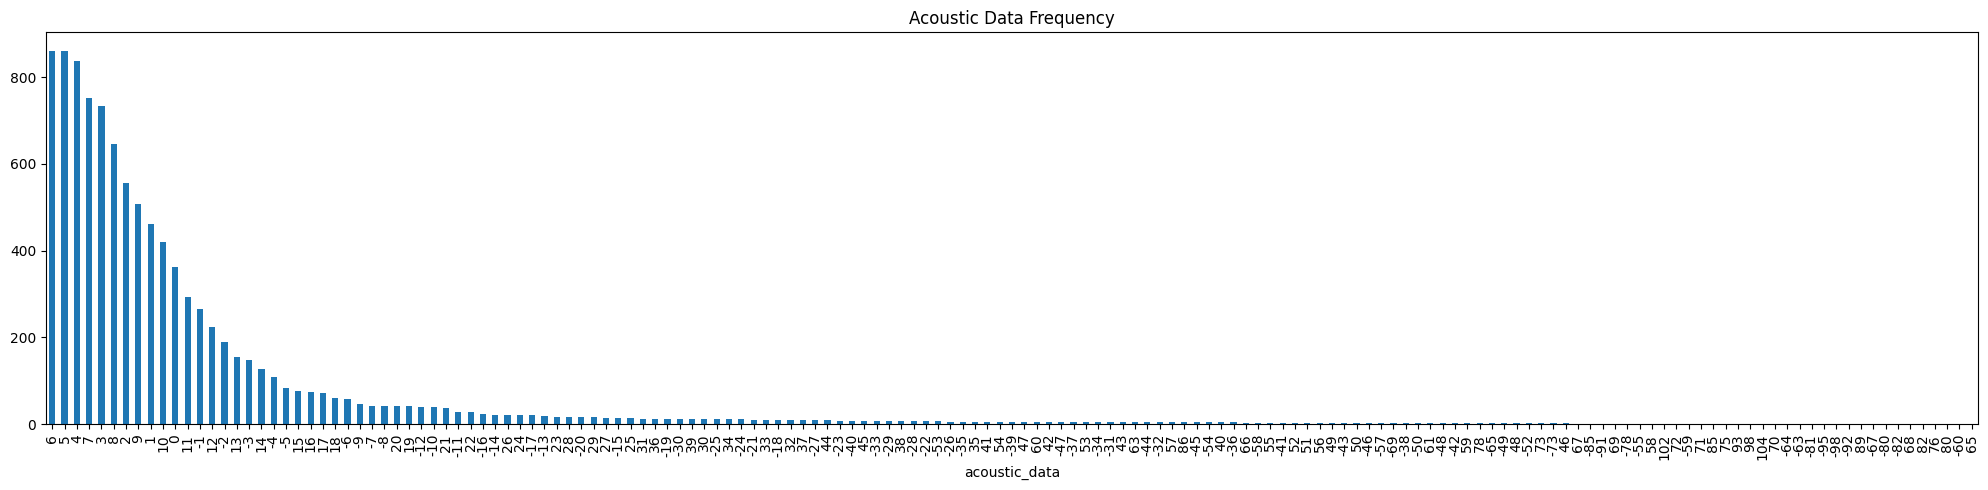

In [12]:
plt.figure(figsize=(20,5))
plt.title('Acoustic Data Frequency')
df['acoustic_data'].value_counts().plot(kind='bar')
plt.tight_layout()

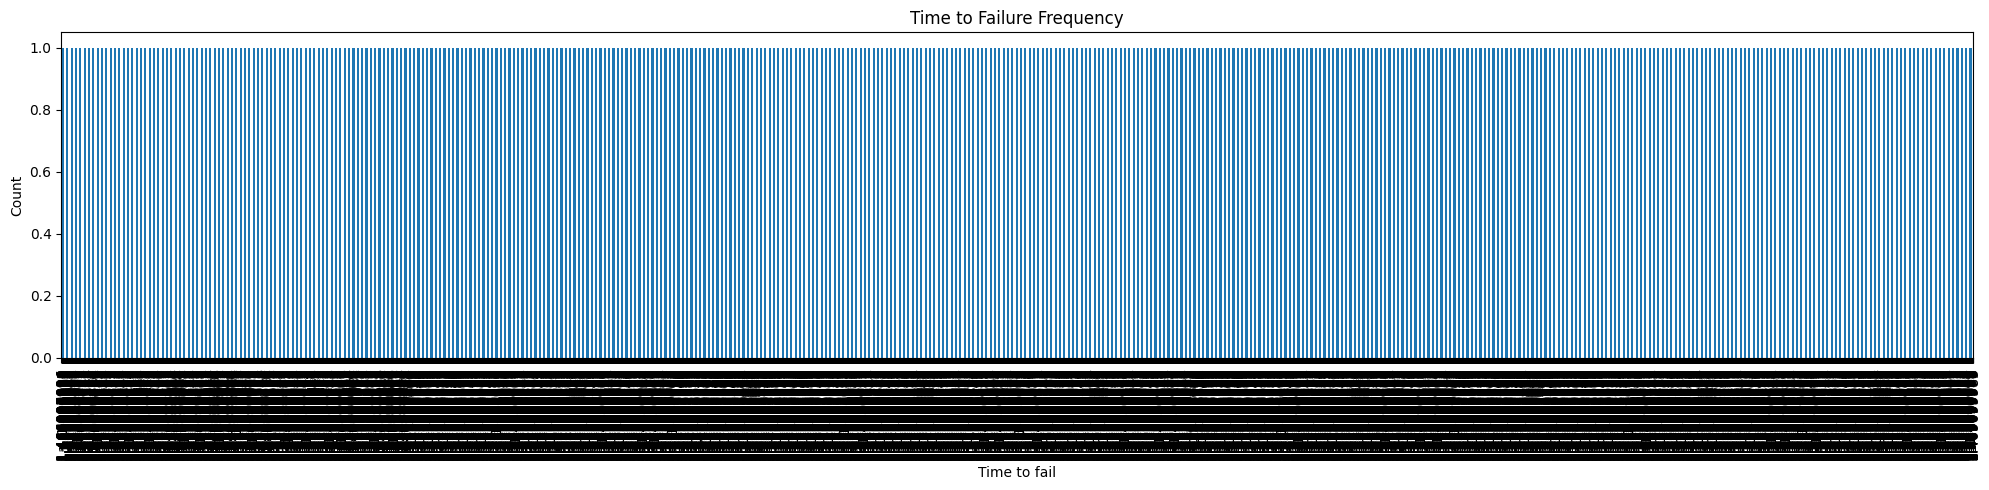

In [11]:
freq_time=df.value_counts('time_to_failure').sort_values(ascending=False)
plt.figure(figsize=(20,5))
plt.title('Time to Failure Frequency')
freq_time.plot(kind='bar')
#labels
plt.xlabel('Time to fail')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [16]:
freq_time.sort_values(ascending=False).head()

time_to_failure
1.466998    1
1.469096    1
1.469096    1
1.469096    1
1.469096    1
Name: count, dtype: int64

In [17]:
freq_time.sort_values(ascending=False).tail()

time_to_failure
1.468097    1
1.468097    1
1.468097    1
1.468097    1
1.469100    1
Name: count, dtype: int64

In [15]:
# missing values
df.isnull().describe().T

,count,unique,top,freq
acoustic_data,10000,1,False,10000
time_to_failure,10000,1,False,10000


In [5]:
wolta.data_tools.col_types(df)

['int64', 'float64']

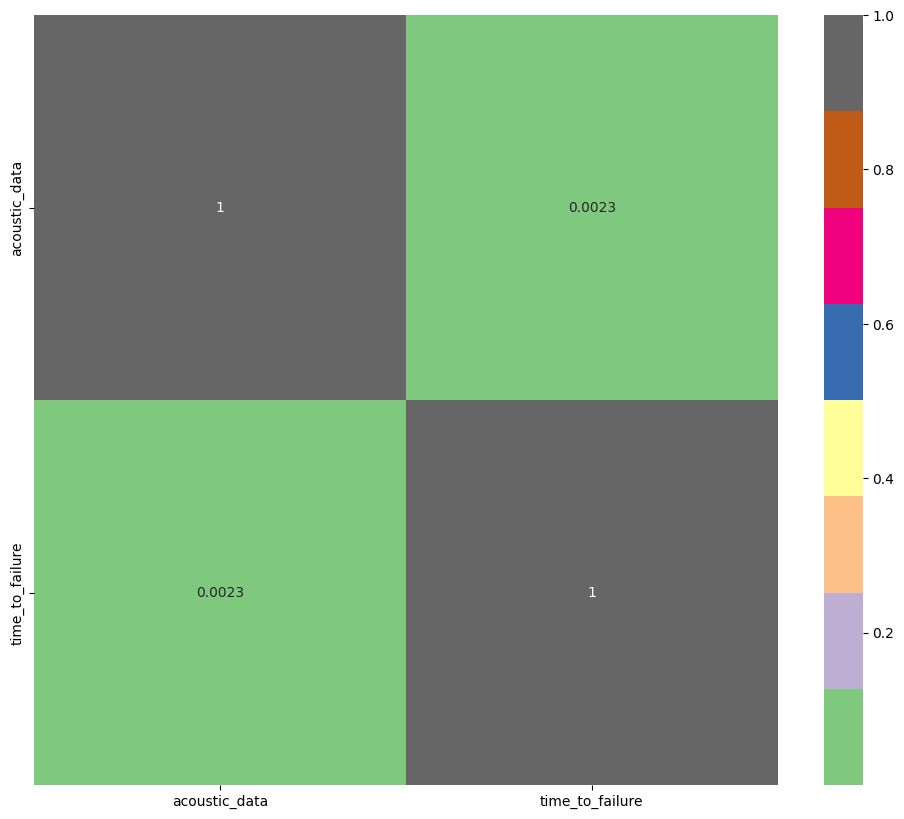

In [6]:
# pearson correlation
df.corr(method='pearson')
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Accent)
plt.show()

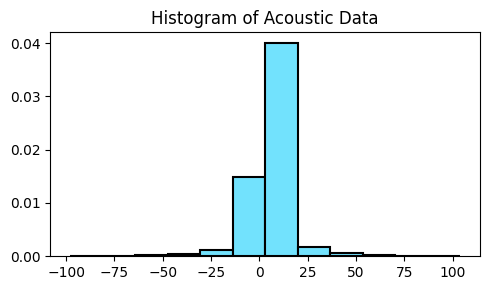

In [10]:
plt.figure(figsize=(5,3))
plt.hist(
    df['acoustic_data'],
    density=True,
    bins=12,
    edgecolor='black',
    linewidth=1.5,
    color='#72e2fd'
)

plt.title('Histogram of Acoustic Data')
plt.tight_layout()
plt.show()

### Do changes in acoustic data (independent/predictor = x) correspond to a time until earthquake (dependent/response = y)?
### Direct linear relationship?

<Figure size 700x600 with 0 Axes>

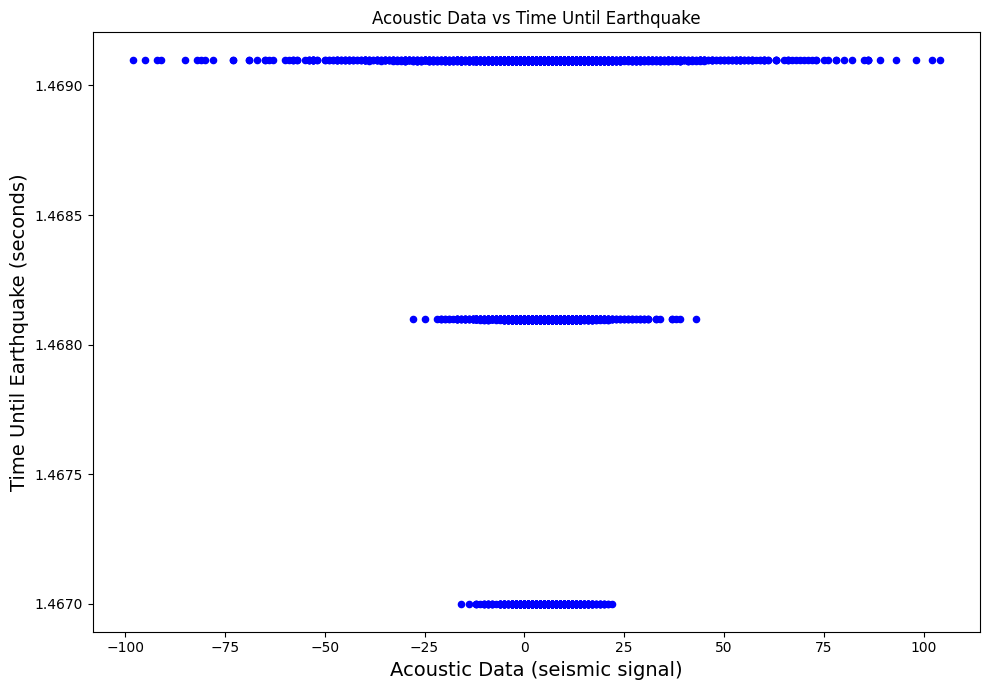

In [31]:
# scatterplot
plt.figure(figsize=(7,6))
df.plot(kind='scatter', x='acoustic_data', y='time_to_failure', color='blue', figsize=(10, 7))
plt.xlabel('Acoustic Data (seismic signal)', size=14)
plt.ylabel('Time Until Earthquake (seconds)', size=14)
plt.title('Acoustic Data vs Time Until Earthquake')
plt.tight_layout()
plt.show()

Correlation: 0.002286560673643025


<Figure size 700x600 with 0 Axes>

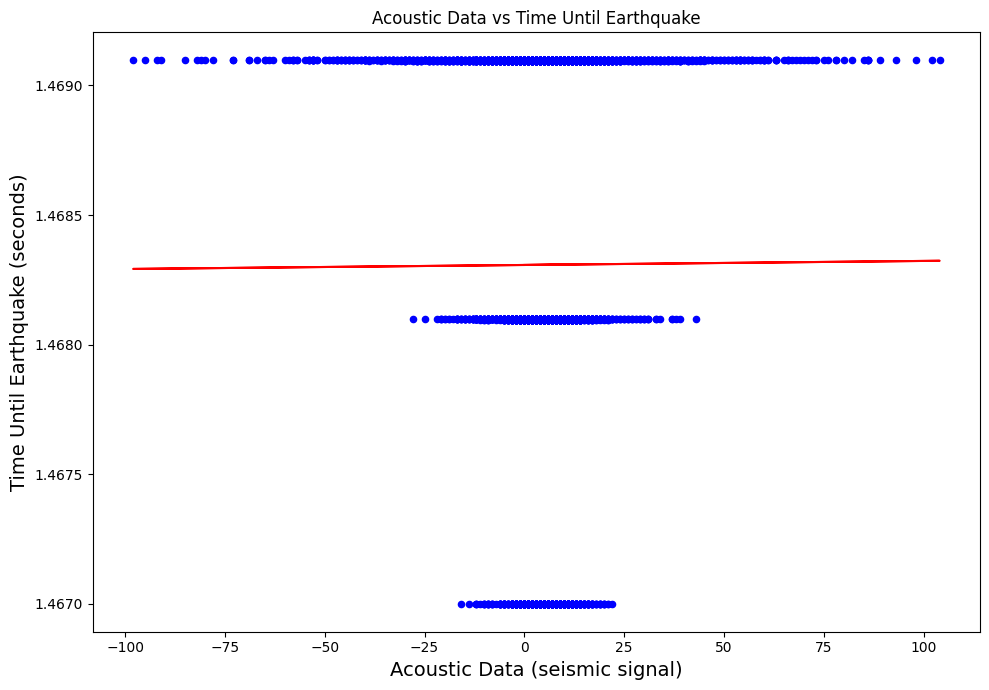

In [40]:
# scatterplot
plt.figure(figsize=(7,6))
x = df['acoustic_data']
y = df['time_to_failure']
df.plot(kind='scatter', x='acoustic_data', y='time_to_failure', color='blue', figsize=(10, 7))

# Fit a linear regression line (y = mx + b)
m, b = np.polyfit(x, y, 1)
# Generate the line for plotting
plt.plot(x, m*x + b, color='red', label=f'Correlation line: y = {m:.2f}x + {b:.2f}')
# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]
print(f'Correlation: {correlation}')

# Labels and plot
plt.xlabel('Acoustic Data (seismic signal)', size=14)
plt.ylabel('Time Until Earthquake (seconds)', size=14)
plt.title('Acoustic Data vs Time Until Earthquake')
plt.tight_layout()
plt.show()

# Questions and WIP:
<br>weak correlation may be due to needing to separate groups of data?
<br>difference in time until earthquake is minimal if it is only fractions of a second ?
<br>but maybe a model can be trained to predict further in time to be more useful?

<br>units of acoustic data are measuring vibrations on a scale from 0 to 16 but how is it negative ?? (acoustic data = the seismic signal [int16])
<br>"This means the values can range from -32,768 to 32,767, allowing for both negative and positive values."
<br>suspected units of a seismic signal can vary based on the type of measurement being taken, but common units include:
<br>
<br>Acceleration: Typically measured in meters per second squared (m/s²) or g (gravity, where 1 g ≈ 9.81 m/s²).
<br>Velocity: Measured in meters per second (m/s).
<br>Displacement: Measured in micrometers (µm) or millimeters (mm).

### Higher time until earthquake = -100 to 100 range with acoustic data
### Least time until earthquake = -25 to 25 acoustic data

In [42]:
range10k = 1.4691 - 1.466998
print(f'Acoustic Data range: {range:.5f} seconds')

Acoustic Data range: 0.00210 seconds


### That is a very small range for this 10k sample.

In [43]:
mil_range = 1.469099983 - 1.19779548
print(f'1 million row acoustic data range: {mil_range:.5f} seconds')

1 million row acoustic data range: 0.27130 seconds


### WIP:
### 1) full range of file is much better, need to random sample from 1,048,576 rows to get 10k rows or less
### 2) separate into groups based upon correlation
### 3) retest correlation